In [ ]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [ ]:
input_path = "../content/DATA_CHAMBER_2021/"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -uq "/content/drive/My Drive/DATA_CHAMBER_2021.zip" -d "./"

In [ ]:
class ImageFolderWithPaths(datasets.ImageFolder):

    # called by dataloaders
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [ ]:
preprocess = {
    'train':
    transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(299),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

image_datasets = {
    'train': 
    ImageFolderWithPaths(input_path + 'train', preprocess['train']),
    'validation': 
    ImageFolderWithPaths(input_path + 'test', preprocess['validation'])
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','validation']}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=2, pin_memory=True),
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=2, pin_memory=True)
}

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=False)
model.AuxLogits.fc = nn.Linear(768, 3)
model.fc = nn.Linear(2048, 3)
# fine tuning

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:83: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


In [ ]:
import torchvision
from torch.autograd import Variable
import time
from PIL import Image
from torchvision import transforms

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9)

In [ ]:
# t0 = time.time()
# print('{} seconds'.format(time.time() - t0)
epochLine = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=1, is_inception = True):
    train_batches = len(dataloaders['train'])
    lossLine = []
    accLine = []
    timeLine = []
    for epoch in range(num_epochs):
        print('-' * 40)
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 20)
        t0 = time.time()

        for phase in ['train']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            training_loss = 0.0
            training_corrects = 0

            for i,data in enumerate(dataloaders[phase]):
                inputs, labels,_ = data
                print("\rTraining batch {}/{}".format(i+1, train_batches), end='', flush=True)
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs,  aux_outputs = model(inputs)
                loss1 = criterion(outputs, labels)
                loss2 = criterion(aux_outputs, labels)
                loss = loss1 + 0.4 * loss2
                # loss.requires_grad = True

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                training_loss += loss.item() * inputs.size(0)
                training_corrects += torch.sum(preds == labels.data)

            epoch_loss = training_loss / len(image_datasets[phase])
            lossLine.append(epoch_loss)
            epoch_acc = training_corrects.double() / len(image_datasets[phase])
            accLine.append(epoch_acc)

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            t1 = time.time()
            t = t1 - t0
            print('Duration :{} seconds'.format(t))
            ts = pd.DataFrame([t]).apply(np.float32)
            timeLine.append(ts)
    return model, lossLine, accLine, timeLine

In [ ]:
model = model.to(device)
model_trained, lossLine, accLine, timeLine = train_model(model, criterion, optimizer, num_epochs=20)

----------------------------------------
Epoch 1/20
--------------------
Training batch 210/210train loss: 1.3005, acc: 0.4975
Duration :216.29078102111816 seconds
----------------------------------------
Epoch 2/20
--------------------
Training batch 210/210train loss: 0.5110, acc: 0.8592
Duration :216.99572587013245 seconds
----------------------------------------
Epoch 3/20
--------------------
Training batch 210/210train loss: 0.0980, acc: 0.9875
Duration :216.79581904411316 seconds
----------------------------------------
Epoch 4/20
--------------------
Training batch 210/210train loss: 0.0454, acc: 0.9945
Duration :218.14732789993286 seconds
----------------------------------------
Epoch 5/20
--------------------
Training batch 210/210train loss: 0.0236, acc: 0.9988
Duration :218.6515884399414 seconds
----------------------------------------
Epoch 6/20
--------------------
Training batch 210/210train loss: 0.0142, acc: 0.9996
Duration :218.6678740978241 seconds
------------------

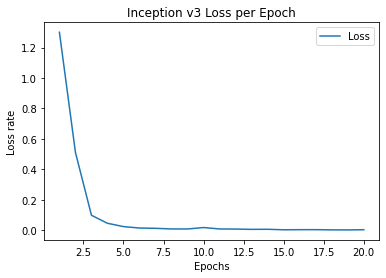

In [ ]:
plt.plot(epochLine, lossLine, label="Loss")
plt.plot()

plt.xlabel("Epochs")
plt.ylabel("Loss rate")
plt.title("Inception v3 Loss per Epoch")
plt.legend()
plt.show()

In [ ]:
print(lossLine)

[1.3004624035558265, 0.5110283091484622, 0.09804020748396475, 0.04536528195545257, 0.023582757646416215, 0.014221105934214304, 0.012269790807953256, 0.008142953431179689, 0.007933895830306266, 0.017453130255307012, 0.008013392896143959, 0.007353934728788251, 0.005472294156851675, 0.005974864220367715, 0.0027468234999555954, 0.0033068033630512675, 0.0035184879943474575, 0.002160698882795929, 0.0017883497439727639, 0.0030692295703291838]


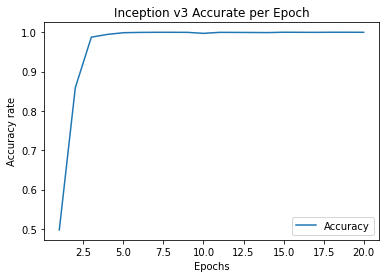

In [ ]:
plt.plot(epochLine, accLine, label="Accuracy")
plt.plot()

plt.xlabel("Epochs")
plt.ylabel("Accuracy rate")
plt.title("Inception v3 Accurate per Epoch")
plt.legend()
plt.show()

In [ ]:
print(accLine)

[tensor(0.4975, device='cuda:0', dtype=torch.float64), tensor(0.8592, device='cuda:0', dtype=torch.float64), tensor(0.9875, device='cuda:0', dtype=torch.float64), tensor(0.9945, device='cuda:0', dtype=torch.float64), tensor(0.9988, device='cuda:0', dtype=torch.float64), tensor(0.9996, device='cuda:0', dtype=torch.float64), tensor(0.9999, device='cuda:0', dtype=torch.float64), tensor(0.9999, device='cuda:0', dtype=torch.float64), tensor(0.9997, device='cuda:0', dtype=torch.float64), tensor(0.9972, device='cuda:0', dtype=torch.float64), tensor(0.9997, device='cuda:0', dtype=torch.float64), tensor(0.9996, device='cuda:0', dtype=torch.float64), tensor(0.9994, device='cuda:0', dtype=torch.float64), tensor(0.9991, device='cuda:0', dtype=torch.float64), tensor(1., device='cuda:0', dtype=torch.float64), tensor(0.9999, device='cuda:0', dtype=torch.float64), tensor(0.9997, device='cuda:0', dtype=torch.float64), tensor(1., device='cuda:0', dtype=torch.float64), tensor(1., device='cuda:0', dtype=t

In [ ]:
total_time_train = 0
for i in timeLine:  total_time_train += i
print(total_time_train)

            0
0  4360.84668


In [ ]:
def test_model(model, criterion, optimizer):
    labels_input=list()
    labels_output=list()
    vid_id = list()
    for phase in ['validation']:
        model.eval()

        for inputs, labels, fname in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_input= labels_input + labels.tolist()
            for f in fname:
                vid_id.append(f.split('/')[-1].split('.')[0].split('_')[0])
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            labels_output= labels_output + preds.tolist()
    return labels_input,labels_output,vid_id
            
y_true,y_pred,vid_id = test_model(model, criterion, optimizer)

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
print(classification_report(y_true,y_pred))
accuracy_score(y_true, y_pred)

              precision    recall  f1-score   support

           0       0.53      0.58      0.55       409
           1       0.52      0.60      0.56       367
           2       0.58      0.51      0.55       831

    accuracy                           0.55      1607
   macro avg       0.54      0.57      0.55      1607
weighted avg       0.56      0.55      0.55      1607



0.551337896701929

In [ ]:
df = pd.DataFrame(list(zip(y_true,y_pred,vid_id)),
               columns =['y_true','y_pred','vid_id'])
df.to_csv('df.csv',encoding='utf-8',index=False)

In [ ]:
vid_list = list(set(df['vid_id'].values))

y_true = []
y_pred = []
for vid in vid_list:
    #print(vid)
    tmp_df = df[df['vid_id']==vid]
    #print(len(tmp_df))
    vid_pred = tmp_df['y_pred'].mode().values[0]
    vid_label = tmp_df['y_true'].mode().values[0]
    y_true.append(vid_label)
    y_pred.append(vid_pred)
    #print(vid_label,"\n",vid_pred)
    
    print('vid: {} label: {} pred: {}'.format(vid,vid_label,vid_pred))

vid: 164 label: 2 pred: 1
vid: 187 label: 2 pred: 1
vid: 172 label: 2 pred: 2
vid: 192 label: 0 pred: 2
vid: 175 label: 1 pred: 1
vid: 189 label: 1 pred: 1
vid: 168 label: 0 pred: 0
vid: 180 label: 2 pred: 2
vid: 167 label: 2 pred: 0
vid: 186 label: 1 pred: 2
vid: 178 label: 0 pred: 2
vid: 159 label: 1 pred: 1
vid: 161 label: 1 pred: 2
vid: 183 label: 0 pred: 0
vid: 193 label: 2 pred: 0
vid: 166 label: 1 pred: 1
vid: 174 label: 1 pred: 1
vid: 195 label: 2 pred: 2
vid: 162 label: 1 pred: 2
vid: 191 label: 0 pred: 0
vid: 190 label: 1 pred: 1
vid: 157 label: 1 pred: 2
vid: 170 label: 2 pred: 2
vid: 194 label: 1 pred: 2
vid: 182 label: 2 pred: 2
vid: 176 label: 0 pred: 0
vid: 179 label: 1 pred: 1
vid: 177 label: 0 pred: 0
vid: 185 label: 1 pred: 1
vid: 160 label: 2 pred: 2
vid: 181 label: 0 pred: 0
vid: 171 label: 0 pred: 2
vid: 188 label: 2 pred: 0
vid: 169 label: 0 pred: 0
vid: 165 label: 0 pred: 0
vid: 184 label: 2 pred: 2
vid: 173 label: 2 pred: 2
vid: 158 label: 0 pred: 0
vid: 163 lab

In [ ]:
accuracy_score(y_true,y_pred)

0.6666666666666666